# Metody klasterujące dla zbioru urbanGB

Julia Kaznowska, Piotr Wilczyński <br>
12/05/2022 <br>
Politechnika Warszawska, Wydział Matematyki i Nauk Informacyjnych, Wstęp do uczenia maszynowego

## Import niezbędnych bibliotek oraz zbioru danych

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# zbior danych
df = pd.read_csv('urbanGB.txt', sep=",", header=None)
df_lab = pd.read_csv('urbanGB_labels.txt', sep=",", header=None)

# wyświetlanie wizualizacji
%matplotlib inline

## Wstępne informacje o danych

Na podstawie informacji o zbiorze danych wiemy, że w kolumnach podane są koordynaty miejsc w Wielkiej Brytanii, w których wydarzyły się wypadki samochodowe. W dodatkowym pliku (`urbanGB.labels.txt`) przedstawiony jest podział na ponad 450 obszarów miejskich, do których należą poszczególne punkty. Informacja ta będzie przydatna do późniejszego wyznaczenia próbki ze zbioru.

In [2]:
df.iloc[:, [0, 1]]  = df.iloc[:, [1, 0]] 
df.columns = ["latitude","longitude"]

In [3]:
df.head()

,latitude,longitude
0,53.7802,-0.310990
1,55.8706,-3.112550
2,51.3806,-0.088533
3,51.4476,-0.326795
4,51.6594,-3.946530


In [4]:
df.shape

(360177, 2)

Zbiór danych zawiera 360177 rekordów i 2 kolumny.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360177 entries, 0 to 360176
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   latitude   360177 non-null  float64
 1   longitude  360177 non-null  float64
dtypes: float64(2)
memory usage: 5.5 MB


W zbiorze nie ma braków danych.

In [6]:
df.describe()

,latitude,longitude
count,360177.000000,360177.000000
mean,52.562117,-1.409118
std,1.374610,1.326356
min,50.079700,-5.555990
25%,51.496200,-2.243070
50%,52.401200,-1.441970
75%,53.474800,-0.205373
max,57.695600,1.758340


## Metoda K-means

Na początku sprawdzamy optymalną liczbę klastrów metodą łokcia.

In [7]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df)
    Sum_of_squared_distances.append(km.inertia_)

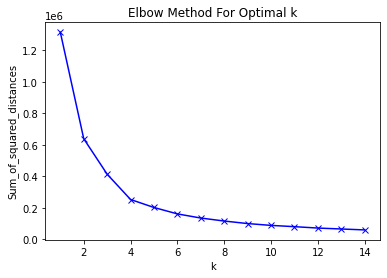

In [8]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Widzimy, że optymalna liczba klastrów wynosi około cztery.

Upewnijmy się jeszcze używając jeszcze silhouette score na próbce:

In [85]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

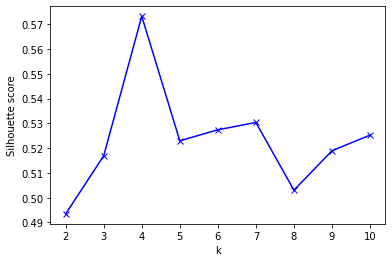

In [89]:
from sklearn.metrics import silhouette_score

df_sample = df.to_numpy()[np.random.randint(0, 300000, 10000)]

cluster_num_seq = range(2, 11)
silhouette_vec = count_clustering_scores(df_sample, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

Optymalną liczbą klastrów wydaje się być 4.

In [9]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(df)
y_kmeans = kmeans.predict(df)

Zwizualizujmy podział punktów na klastry:

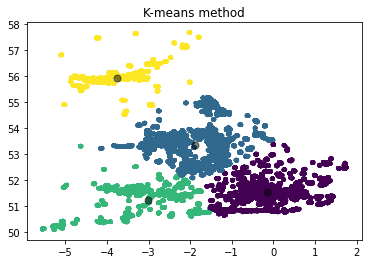

In [10]:
plt.scatter(df.iloc[:, 1], df.iloc[:, 0], c=y_kmeans, s=10, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=50, alpha=0.5)
plt.title("K-means method");

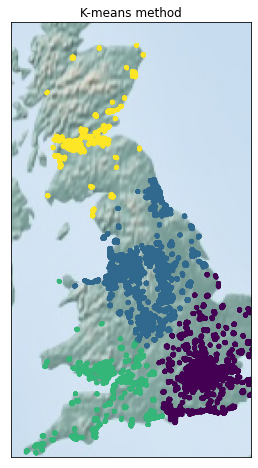

In [11]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(8, 8))
lat = df.iloc[:, 0].tolist()
lon = df.iloc[:, 1].tolist()
m = Basemap(projection='lcc', llcrnrlon=-6.,llcrnrlat=50.,urcrnrlon=2.,urcrnrlat=58.,
           lat_0 = 50, lon_0 = -4)
m.shadedrelief()

m.scatter(lon, lat, latlon=True,
          c=y_kmeans, s=10,
          cmap='viridis', alpha=0.5)
plt.title("K-means method");

## Metoda aglomeracyjna

Z uwagi na bardzo duży rozmiar danych przygotowujemy próbkę:

In [12]:
df["label"] = df_lab

In [13]:
y = np.array(df["label"])
X = df.drop(["label"], axis = 1)
X_build, sample, y_build, y_val = train_test_split(
    X, y, stratify=y, test_size=0.05, random_state=321
)

Aby wyznaczyć optymalną liczbę klastrów posłużymy się dendrogramem:

In [14]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [15]:
link = sch.linkage(sample, method='ward')

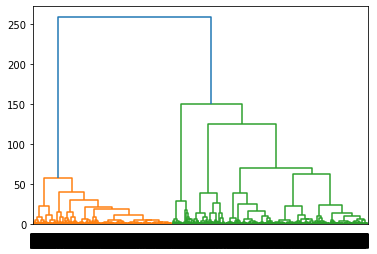

In [16]:
dendrogram = sch.dendrogram(link)

Optymalna liczba klastrów wynosi ponownie 4.

In [17]:
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
model.fit(sample)
labels = model.labels_
y_pred = model.fit_predict(sample)

Wizualizacje podziału punktów na klastry:

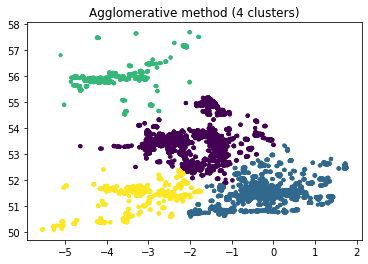

In [23]:
plt.scatter(sample.iloc[:,1], sample.iloc[:,0], c=y_pred, s=10, cmap='viridis')
plt.title("Agglomerative method (4 clusters)");

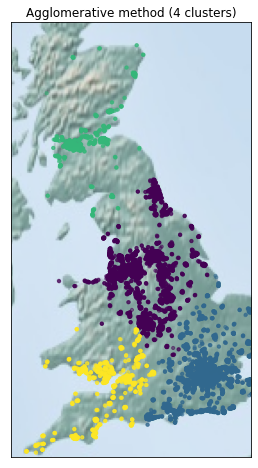

In [24]:
fig = plt.figure(figsize=(8, 8))
lat = sample.iloc[:, 0].tolist()
lon = sample.iloc[:, 1].tolist()
m = Basemap(projection='lcc', llcrnrlon=-6.,llcrnrlat=50.,urcrnrlon=2.,urcrnrlat=58.,
           lat_0 = 50, lon_0 = -4)
m.shadedrelief()

m.scatter(lon, lat, latlon=True,
          c=y_pred, s=10,
          cmap='viridis', alpha=0.5)
plt.title("Agglomerative method (4 clusters)");

Widzimy, że klastry w metodach `K-means` i `aglomeracyjnej` są do siebie bardzo podobne.

## DBSCAN

Poprzednie metody miały jedną znaczącą wadę - do klasteyzacji używały metryki euklidesowej. Danymi są długość i szerokość geograficzna, więc aby poprawnie obliczać odległości między punktami należy wziąć pod uwagę krzywiznę Ziemi (metryka euklidesowa daje tylko przybliżoną wartość).

Dobieramy $\texttt{minPts}$ oraz $\varepsilon$ zgodnie z sugestiami autorów algorytmu.

In [45]:
# zamiana stopni na radiany
df_rad = pd.DataFrame()
df_rad[0] = np.deg2rad(df.iloc[:, 0])
df_rad[1] = np.deg2rad(df.iloc[:, 1])
df_rad.columns = ["latitude", "longitude"]

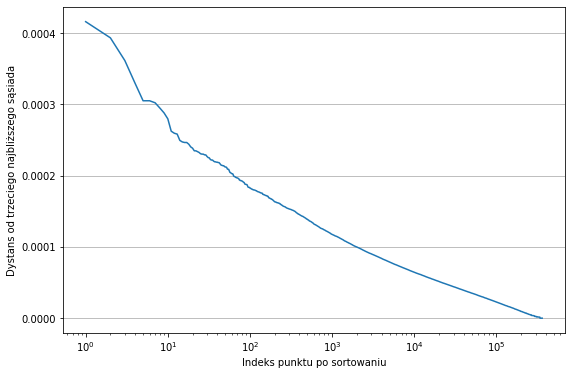

In [47]:
from sklearn.neighbors import NearestNeighbors
minPts = 2*2
nbrs = NearestNeighbors(n_neighbors=minPts, algorithm = 'ball_tree', metric = 'haversine').fit(df_rad)
distances, indices = nbrs.kneighbors(df_rad)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,df_rad.shape[0]+1)), distanceDec)

plt.xscale('log')
plt.grid(axis='y')

plt.show()

Trudno z wykresu wyznaczyć prawidłowy epsilon. Weźmy ten po największym spadku ( ok 0.0002 ).

In [82]:
from sklearn.cluster import DBSCAN
eps = 0.0002
db = DBSCAN(eps=eps, min_samples=minPts, algorithm='ball_tree', metric='haversine')
y_db = db.fit_predict(df_rad)

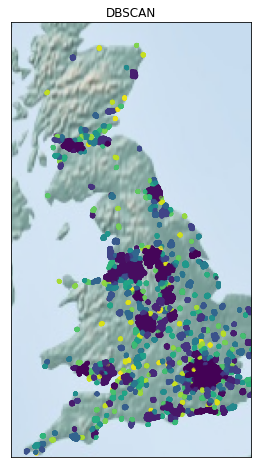

In [83]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(8, 8))
lat = df.iloc[:, 0].tolist()
lon = df.iloc[:, 1].tolist()
m = Basemap(projection='lcc', llcrnrlon=-6.,llcrnrlat=50.,urcrnrlon=2.,urcrnrlat=58.,
           lat_0 = 50, lon_0 = -4)
m.shadedrelief()

m.scatter(lon, lat, latlon=True,
          c=y_db, s=10,
          cmap='viridis', alpha=0.5)
plt.title("DBSCAN");

Porównajmy wydzielone klastry z oryginalnie wydzielonym podziałem:

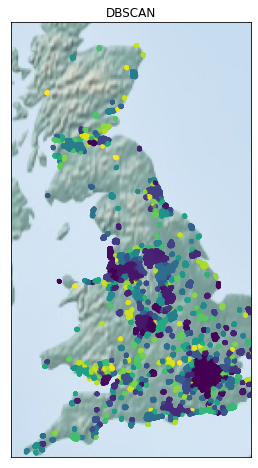

In [76]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(8, 8))
lat = df.iloc[:, 0].tolist()
lon = df.iloc[:, 1].tolist()
m = Basemap(projection='lcc', llcrnrlon=-6.,llcrnrlat=50.,urcrnrlon=2.,urcrnrlat=58.,
           lat_0 = 50, lon_0 = -4)
m.shadedrelief()

m.scatter(lon, lat, latlon=True,
          c=df_lab, s=10,
          cmap='viridis', alpha=0.5)
plt.title("DBSCAN");

Wizualnie widać podobieństwo między wydzielonymi klastrami.

In [84]:
np.unique(y_db)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [78]:
np.unique(df_lab)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

W otrzymanym podziale znajduje się 468 klastrów. W oryginalnym jest ich 469.

Trudno stwierdzić jaka liczba klastrów jest "najlepsza". Być może otrzymaliśmy prawidłowy podział. Spróbujmy jednak zredukować ich liczbę.

In [71]:
from sklearn.cluster import DBSCAN
eps = 0.001
db = DBSCAN(eps=eps, min_samples=50, algorithm='ball_tree', metric='haversine')
y_db = db.fit_predict(df_rad)

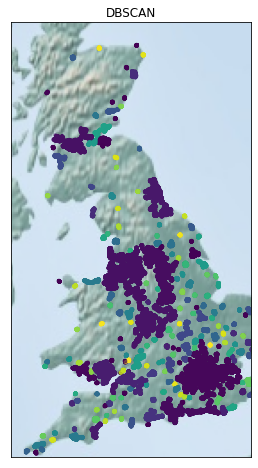

In [74]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(8, 8))
lat = df.iloc[:, 0].tolist()
lon = df.iloc[:, 1].tolist()
m = Basemap(projection='lcc', llcrnrlon=-6.,llcrnrlat=50.,urcrnrlon=2.,urcrnrlat=58.,
           lat_0 = 50, lon_0 = -4)
m.shadedrelief()

m.scatter(lon, lat, latlon=True,
          c=y_db, s=10,
          cmap='viridis', alpha=0.5)
plt.title("DBSCAN");

In [75]:
np.unique(y_db)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171], dtype=int64)

Nie da się dużo bardziej zredukować liczby klastrów ze względu na ogarniczoną pamięć.

## Podsumowanie

Mimo początkowego podziału na ponad 450 klastrów reprezentujących obszary miejskie okazuje się, że optymalna liczba podziałów w metodach `k-means` i `aglomeracyjnej` to 4 klastry. Zdecydowanie zmienia to interpretowalność danych - nie możemy teraz mówić o podziale na obszary miejskie, tylko na regiony. Zwiększanie liczby klastrów nie wprowadziłoby znaczącej poprawy w jakości podziału, zajęłoby jednak dużo więcej czasu.

Metoda `DBSCAN` używająca metryki odległości na sferze znajduje podobne klastry jak te, które były wyznaczone oryginalnie. Nie da się jednak tą metododą otrzymać klastrów podobnych jak w poprzednich metodach ze względu na ograniczenie pamięci.